<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(model_save)Strong_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Set Dataset and model

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os
from torchsummary import summary
from copy import deepcopy
import os

In [30]:
def save_checkpoint(epoch, model, optimizer, path): 
    state = { 'Epoch': epoch,
             'State_dict': model.state_dict(),
             'optimizer': optimizer.state_dict() 
             }
    torch.save(state, path)

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [11]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [12]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [13]:
batch_size = 1024
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [14]:
strong_transform = transforms.Compose([
                    transforms.ToTensor(),                     
                    transforms.GaussianBlur(kernel_size=(7,7),sigma=3), #
])

Original Train/Validation/Test dataset

In [15]:
org_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)
tr_subset, val_subset = torch.utils.data.random_split(org_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = transforms.ToTensor(), download=True)



  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


Strong_hat Train/Validation/Test dataset


In [16]:
strong_hat_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = strong_transform, download=False)
strong_hat_tr_subset, strong_hat_val_subset = torch.utils.data.random_split(strong_hat_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
strong_hat_test_set = datasets.STL10(root = "./data", split = "test",transform = strong_transform, download=False)

# Original / Gaussian Blur DataLoader

In [17]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2, pin_memory=True)


# Moderate Gaussian Blur DataLoader

# Strong Gaussian Blur

In [18]:
strong_hat_tr_dataloader = DataLoader(strong_hat_tr_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)
strong_hat_val_dataloader = DataLoader(strong_hat_val_subset, batch_size = batch_size, num_workers = 2, pin_memory=True) # 여기서 hat_val_subset을 안 넣는 치명적인 실수.
strong_hat_test_dataloader = DataLoader(strong_hat_test_set, batch_size = batch_size, num_workers = 2, pin_memory=True)

In [12]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


# Model. Setting parameter -> float

In [19]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
    # 96 by 96 by 3
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
    # 48 by 48 by 32
        nn.ReLU(True),



        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 
        nn.BatchNorm2d(128),
        nn.ReLU(True),


        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(256),
    # 6 by 6 by 256
        nn.ReLU(True),


        nn.Flatten(start_dim=1),
    )
    self.decoder = nn.Sequential(
        nn.Unflatten(dim=1,unflattened_size = (256,6,6)),
    # 6 by 6 by 256

        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

    # 12 by 12 by 128  
        
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),


    # 24 by 24 by 64
        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(True),   
    
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(3),

    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
ve

# Strong DAE train Mode

cuda
Epoch : [1/50] 

Training Loss: 0.035063	 validation Loss 0.024327
Epoch : [2/50] 

Training Loss: 0.014767	 validation Loss 0.020147
Epoch : [3/50] 

Training Loss: 0.010652	 validation Loss 0.013685
Epoch : [4/50] 

Training Loss: 0.008641	 validation Loss 0.011115
Epoch : [5/50] 

Training Loss: 0.007437	 validation Loss 0.009273
PNSR :15.18 	 SSIM : 0.52
PNSR :16.03 	 SSIM : 0.60
PNSR :15.50 	 SSIM : 0.63
PNSR :15.74 	 SSIM : 0.59
PNSR :16.75 	 SSIM : 0.51


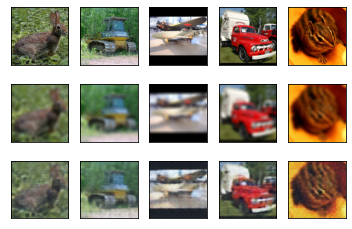

Epoch : [6/50] 

Training Loss: 0.006592	 validation Loss 0.007751
Epoch : [7/50] 

Training Loss: 0.006004	 validation Loss 0.007288
Epoch : [8/50] 

Training Loss: 0.005586	 validation Loss 0.006742
Epoch : [9/50] 

Training Loss: 0.005276	 validation Loss 0.006593
Epoch : [10/50] 

Training Loss: 0.005012	 validation Loss 0.005936
PNSR :16.33 	 SSIM : 0.60
PNSR :17.29 	 SSIM : 0.66
PNSR :18.21 	 SSIM : 0.67
PNSR :17.14 	 SSIM : 0.67
PNSR :20.51 	 SSIM : 0.59


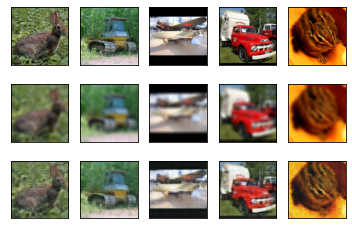

Epoch : [11/50] 

Training Loss: 0.004835	 validation Loss 0.005695
Epoch : [12/50] 

Training Loss: 0.004696	 validation Loss 0.005852
Epoch : [13/50] 

Training Loss: 0.004540	 validation Loss 0.005469
Epoch : [14/50] 

Training Loss: 0.004439	 validation Loss 0.005226
Epoch : [15/50] 

Training Loss: 0.004329	 validation Loss 0.005094
PNSR :16.76 	 SSIM : 0.64
PNSR :17.90 	 SSIM : 0.69
PNSR :19.36 	 SSIM : 0.69
PNSR :18.10 	 SSIM : 0.70
PNSR :20.68 	 SSIM : 0.62


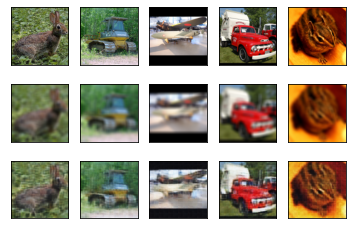

Epoch : [16/50] 

Training Loss: 0.004266	 validation Loss 0.004960
Epoch : [17/50] 

Training Loss: 0.004171	 validation Loss 0.005078
Epoch : [18/50] 

Training Loss: 0.004122	 validation Loss 0.005096
Epoch : [19/50] 

Training Loss: 0.004062	 validation Loss 0.004567
Epoch : [20/50] 

Training Loss: 0.004002	 validation Loss 0.004907
PNSR :17.04 	 SSIM : 0.64
PNSR :17.63 	 SSIM : 0.69
PNSR :19.47 	 SSIM : 0.69
PNSR :18.14 	 SSIM : 0.71
PNSR :19.45 	 SSIM : 0.64


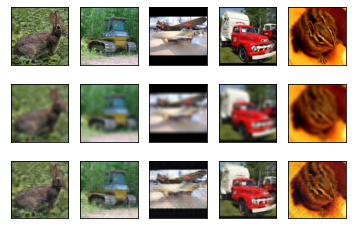

Epoch : [21/50] 

Training Loss: 0.003942	 validation Loss 0.004800
Epoch : [22/50] 

Training Loss: 0.003917	 validation Loss 0.004854
Epoch : [23/50] 

Training Loss: 0.003855	 validation Loss 0.004825
Epoch : [24/50] 

Training Loss: 0.003838	 validation Loss 0.004509
Epoch : [25/50] 

Training Loss: 0.003780	 validation Loss 0.004548
PNSR :17.26 	 SSIM : 0.67
PNSR :17.95 	 SSIM : 0.71
PNSR :21.07 	 SSIM : 0.71
PNSR :18.81 	 SSIM : 0.74
PNSR :19.71 	 SSIM : 0.66


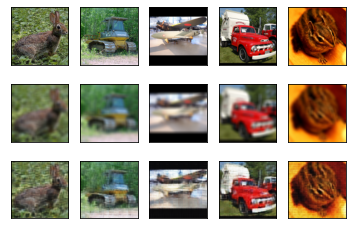

Epoch : [26/50] 

Training Loss: 0.003779	 validation Loss 0.004365
Epoch : [27/50] 

Training Loss: 0.003728	 validation Loss 0.004297
Epoch : [28/50] 

Training Loss: 0.003691	 validation Loss 0.004264
Epoch : [29/50] 

Training Loss: 0.003646	 validation Loss 0.004462
Epoch : [30/50] 

Training Loss: 0.003614	 validation Loss 0.004251
PNSR :17.18 	 SSIM : 0.67
PNSR :18.09 	 SSIM : 0.72
PNSR :21.21 	 SSIM : 0.73
PNSR :19.24 	 SSIM : 0.74
PNSR :21.05 	 SSIM : 0.68


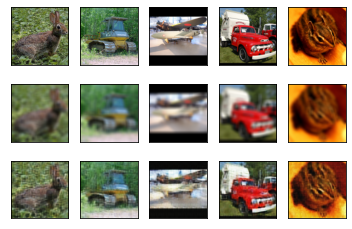

Epoch : [31/50] 

Training Loss: 0.003571	 validation Loss 0.004437
Epoch : [32/50] 

Training Loss: 0.003581	 validation Loss 0.004122
Epoch : [33/50] 

Training Loss: 0.003529	 validation Loss 0.004767
Epoch : [34/50] 

Training Loss: 0.003517	 validation Loss 0.004275
Epoch : [35/50] 

Training Loss: 0.003509	 validation Loss 0.004274
PNSR :17.32 	 SSIM : 0.68
PNSR :18.26 	 SSIM : 0.73
PNSR :21.22 	 SSIM : 0.73
PNSR :19.22 	 SSIM : 0.76
PNSR :20.36 	 SSIM : 0.69


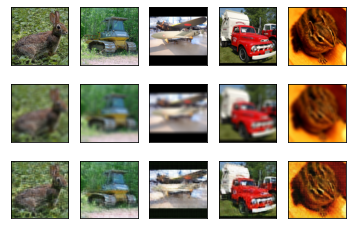

Epoch : [36/50] 

Training Loss: 0.003487	 validation Loss 0.004431
Epoch : [37/50] 

Training Loss: 0.003458	 validation Loss 0.004102
Epoch : [38/50] 

Training Loss: 0.003473	 validation Loss 0.004325
Epoch : [39/50] 

Training Loss: 0.003455	 validation Loss 0.004137
Epoch : [40/50] 

Training Loss: 0.003412	 validation Loss 0.003903
PNSR :17.77 	 SSIM : 0.69
PNSR :17.69 	 SSIM : 0.73
PNSR :21.28 	 SSIM : 0.75
PNSR :18.47 	 SSIM : 0.76
PNSR :22.04 	 SSIM : 0.72


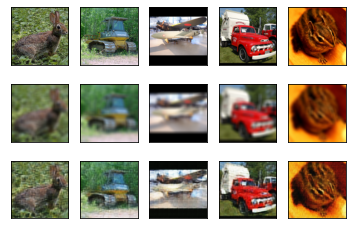

Epoch : [41/50] 

Training Loss: 0.003414	 validation Loss 0.004368
Epoch : [42/50] 

Training Loss: 0.003391	 validation Loss 0.004206
Epoch : [43/50] 

Training Loss: 0.003397	 validation Loss 0.004342
Epoch : [44/50] 

Training Loss: 0.003401	 validation Loss 0.003968
Epoch : [45/50] 

Training Loss: 0.003384	 validation Loss 0.004311
PNSR :17.48 	 SSIM : 0.67
PNSR :17.47 	 SSIM : 0.72
PNSR :20.80 	 SSIM : 0.74
PNSR :19.40 	 SSIM : 0.75
PNSR :21.63 	 SSIM : 0.71


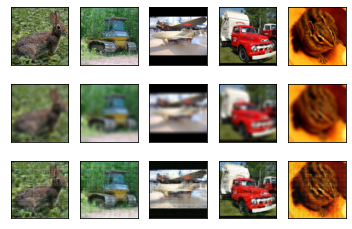

Epoch : [46/50] 

Training Loss: 0.003367	 validation Loss 0.004333
Epoch : [47/50] 

Training Loss: 0.003344	 validation Loss 0.003877
Epoch : [48/50] 

Training Loss: 0.004257	 validation Loss 0.012426
Epoch : [49/50] 

Training Loss: 0.004505	 validation Loss 0.004726
Epoch : [50/50] 

Training Loss: 0.003704	 validation Loss 0.004241
PNSR :17.03 	 SSIM : 0.67
PNSR :18.09 	 SSIM : 0.71
PNSR :22.45 	 SSIM : 0.73
PNSR :18.69 	 SSIM : 0.74
PNSR :21.32 	 SSIM : 0.69


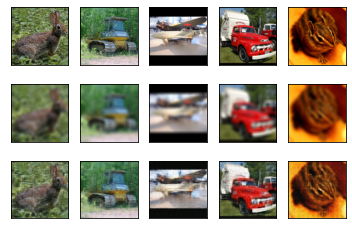

execution time : 63.2min


In [41]:

n_epochs = 50

device = get_device()
print(device)

model_strong = DenosingAutoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.train()
    time.sleep(1.0)
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, hat_img) in enumerate(zip(tr_dataloader,strong_hat_tr_dataloader)):
        tr_images,_ = tr_img
#        print(tr_images_arr.shape)
        hat_tr_images,_ = hat_img
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.to(device) #데이터 형식이 Byte이기 때문에 신경망 성분인 float으로 변환해야 한다.
#check   print(tr_images.shape)
        tr_outputs =model_strong(hat_tr_images)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        tr_images = tr_images.to(device)
        loss = mse_loss(tr_outputs, tr_images).to(device) #여기에 쿠다를 부착하니 성능 급 상승함.
        loss.backward()#.to(device)
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    time.sleep(1.0)
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, strong_hat_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                hat_val_img = hat_val_img.to(device)
                val_outputs =model_strong(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_img = val_img.to(device)
                val_loss = mse_loss(val_outputs, val_img)#.to(device)
                val_loss = val_loss.item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%5 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

## Epoch10일 때임. 

In [25]:
from torchvision.utils import save_image

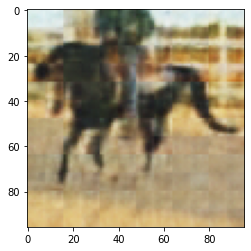

In [22]:

model_strong.eval()

test_img, _ = next(iter(strong_hat_test_dataloader))

test_img  = test_img.to(device)
model_strong = model_strong.to(device)
output = model_strong(test_img)
plt.imshow(output[0].cpu().detach().numpy().transpose(1,2,0))

In [27]:
save_image(output[0],'output1.png')
save_image(test_img[0],'input1.png')


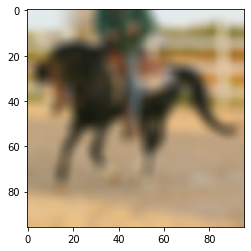

In [23]:
plt.imshow(test_img[0].cpu().detach().numpy().transpose(1,2,0))

In [15]:
summary(model_strong,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             416
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]           8,256
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]          32,896
       BatchNorm2d-8          [-1, 128, 12, 12]             256
              ReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         131,328
      BatchNorm2d-11            [-1, 256, 6, 6]             512
             ReLU-12            [-1, 256, 6, 6]               0
          Flatten-13                 [-1, 9216]               0
        Unflatten-14            [-1, 25

In [16]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model_strong.state_dict():
    print(param_tensor, "\t", model_strong.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer_strong.state_dict():
    print(var_name, "\t", optimizer_strong.state_dict()[var_name])

Model's state_dict:
encoder.0.weight 	 torch.Size([32, 3, 2, 2])
encoder.0.bias 	 torch.Size([32])
encoder.1.weight 	 torch.Size([32])
encoder.1.bias 	 torch.Size([32])
encoder.1.running_mean 	 torch.Size([32])
encoder.1.running_var 	 torch.Size([32])
encoder.1.num_batches_tracked 	 torch.Size([])
encoder.3.weight 	 torch.Size([64, 32, 2, 2])
encoder.3.bias 	 torch.Size([64])
encoder.4.weight 	 torch.Size([64])
encoder.4.bias 	 torch.Size([64])
encoder.4.running_mean 	 torch.Size([64])
encoder.4.running_var 	 torch.Size([64])
encoder.4.num_batches_tracked 	 torch.Size([])
encoder.6.weight 	 torch.Size([128, 64, 2, 2])
encoder.6.bias 	 torch.Size([128])
encoder.7.weight 	 torch.Size([128])
encoder.7.bias 	 torch.Size([128])
encoder.7.running_mean 	 torch.Size([128])
encoder.7.running_var 	 torch.Size([128])
encoder.7.num_batches_tracked 	 torch.Size([])
encoder.9.weight 	 torch.Size([256, 128, 2, 2])
encoder.9.bias 	 torch.Size([256])
encoder.10.weight 	 torch.Size([256])
encoder.10.bia

In [18]:
1

1

In [ ]:
model_name = 'Gaussian_strong_debluring_model_renew'

path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{model_name}'

save_checkpoint(epoch, model_strong, optimizer_strong, path)

In [38]:
#여기에 옵티마이저도 다시 로딩시켜야 한다.

epoch_300_model_name = 'Gaussian_strong_debluring_model'
path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{epoch_300_model_name}'

epoch_300_strong_load = DenosingAutoencoder()
epoch_300_optimizer =  torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
epoch_300_strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
epoch_300_strong_load = epoch_300_strong_load.to(device)

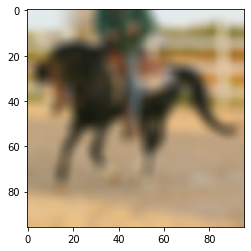

In [39]:
epoch_300_strong_load.eval()

load_img,_ = next(iter(strong_hat_test_dataloader))
plt.imshow(load_img[0].numpy().transpose(1,2,0))

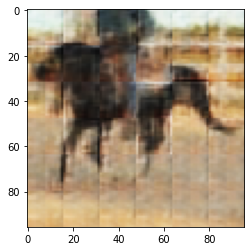

In [40]:
load_img = load_img.to(device)
load_output_img = epoch_300_strong_load(load_img)
load_output_img.shape
plt.imshow(load_output_img[0].detach().cpu().numpy().transpose(1,2,0))


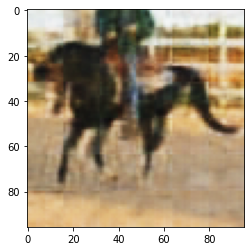

In [37]:
load_img = load_img.to(device)
load_output_img = strong_load(load_img)
load_output_img.shape
plt.imshow(load_output_img[0].detach().cpu().numpy().transpose(1,2,0))


In [37]:
model_name = 'Gaussian_strong_debluring_model_renew'
path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{model_name}'

device = torch.device("cuda")
strong_load = DenosingAutoencoder()
strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
strong_load_optimizer.load_state_dict(torch.load(path, map_location="cuda:0"))
strong_load = strong_load.to(device)

RuntimeError: ignored

In [33]:
device = torch.device("cuda")
strong_load = DenosingAutoencoder()
strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
strong_load = strong_load.to(device)

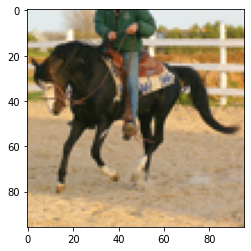

In [34]:
load_origin_img,_ = next(iter(test_dataloader))
plt.imshow(load_origin_img[0].numpy().transpose(1,2,0))

In [22]:
load_img[0].shape

torch.Size([3, 96, 96])

In [23]:
load_img.shape

torch.Size([2048, 3, 96, 96])

# strong test

# strong graph

# test graph for (average psnr, ssim)

In [30]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


NameError: ignored

In [ ]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

In [ ]:
print(img[0].shape)